## 多因子组合

1. 读取本地数据
2. 数据预处理
3. 多因子组合方法
4. 查看因子组合绩效
5. 交集与并集组合的方法

## 1_读取本地数据

In [1]:
from jaqs.data.dataapi import DataApi
from jaqs.data import DataView
import numpy as np
from datetime import datetime
import pandas as pd
import warnings
import alphalens

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = df_index_member ==0 #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

In [3]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()
price = dv.get_ts('close_adj')
price_bench = dv.data_benchmark

Add formula failed: name [up_limit] exist. Try another name.
Add formula failed: name [down_limit] exist. Try another name.


In [4]:
all_factors = ['pb', 'roe', 'price_div_dps', 'ps_ttm', 'pe_ttm', 'roa']

## 2_数据预处理
1. 去极值，标准化，加干扰项
2. 修改名称索引
3. 计算IC的相关系数，并剔除高相关性的因子

In [5]:
origin_factors = {f: dv.get_ts(f) for f in all_factors}

**1. 去极值，标准化，加干扰项**

In [6]:
from jaqs.research import process

#去极值,z_score标准化,加干扰值
factor_dict = {name: process.get_disturbed_factor(process.standardize(process.winsorize(frame)))\
                         for name, frame in origin_factors.items()}

**2. 修改名称索引**

In [7]:
def change_columns_index(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    return signal

In [8]:
price_time = change_columns_index(price)

**3. 计算IC的相关系数，并剔除高相关性的因子**

In [9]:
def cal_daily_ic(factor_df):
    factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_df.stack(), price_time, quantiles=5)
    return alphalens.performance.mean_information_coefficient(factor_data, by_time='D')

daily_ic = {key: cal_daily_ic(change_columns_index(value)) for key, value in factor_dict.items()}
daily_panel = pd.Panel(daily_ic)

In [10]:
factor_corr = daily_panel.minor_xs(5).corr()

In [11]:
print(factor_corr)

                     pb    pe_ttm  price_div_dps    ps_ttm       roa       roe
pb             1.000000  0.858428       0.764783  0.913597  0.689696  0.229572
pe_ttm         0.858428  1.000000       0.823935  0.807155  0.376659 -0.169861
price_div_dps  0.764783  0.823935       1.000000  0.699770  0.320101 -0.109434
ps_ttm         0.913597  0.807155       0.699770  1.000000  0.615621  0.244025
roa            0.689696  0.376659       0.320101  0.615621  1.000000  0.789137
roe            0.229572 -0.169861      -0.109434  0.244025  0.789137  1.000000


In [12]:
ic = daily_panel.minor_xs(5).mean()

In [13]:
def compare(corr, targets):
    index = list(reversed(targets.index))
    length = len(index)
    for i in range(length):
        name = index[i]
        if available(corr, name, index[i+1:]):
            yield name

In [14]:
def available(corr, target, compares):
    for c in compares:
        if corr.loc[target, c] > 0.9 or (corr.loc[target, c] < -0.9 ):
            return False
    return True

In [15]:
for i in compare(factor_corr, ic.nlargest(2)):
    print(i)

roe
roa


In [16]:
big_dict = {i: factor_dict[i] for i in compare(factor_corr, ic.nlargest(2))}

## 3_多因子组合方法
1. combine_factors的equal_weight(等权重加权)
2. combine_factors的max_IR_props(动态加权_最大化IR)

**1. combine_factors的equal_weight(等权重加权)**

In [17]:
from jaqs.research import multi_factor
Equal_Portfolio = multi_factor.combine_factors(big_dict,
                                      standardize_type="z_score",
                                      winsorization=False,
                                      weighted_method="equal_weight",
                                      max_IR_props=None)

In [18]:
print(Equal_Portfolio.tail(1))

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000021.SZ  \
trade_date                                                                     
20171222    -0.346562  -0.171129  -0.823929  -0.656348   0.081882  -0.025089   

symbol      000024.SZ  000027.SZ  000031.SZ  000039.SZ    ...      601998.SH  \
trade_date                                                ...                  
20171222    -0.411117   -0.70641   -0.22589  -0.646009    ...       -0.36197   

symbol      603000.SH  603160.SH  603288.SH  603699.SH  603799.SH  603833.SH  \
trade_date                                                                     
20171222    -1.052117   3.039816   2.988756  -0.184505   1.917662   2.297176   

symbol      603858.SH  603885.SH  603993.SH  
trade_date                                   
20171222      0.39488   0.967938  -0.389438  

[1 rows x 539 columns]


**2. combine_factors的max_IRprops(动态加权最大化IR)**

In [19]:
price_bench = dv.data_benchmark

max_IR_props = {
    'price': price,
    'benchmark_price': price_bench,# 为空计算的是绝对收益　不为空计算相对收益
    'period': 5,
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "simple",  #协方差矩阵估算方法 还可以为"shrink" 
    "rollback_period": 30} #用多少期的ic做权重计算

In [20]:
Factor_Portfolio = multi_factor.combine_factors(big_dict,
                                      standardize_type="rank",
                                      winsorization=False,
                                      weighted_method="max_IR",
                                      max_IR_props=max_IR_props)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


In [21]:
print(Factor_Portfolio.tail(1))

symbol      000001.SZ  000002.SZ  000008.SZ  000009.SZ  000012.SZ  000021.SZ  \
trade_date                                                                     
20171222     0.664193   0.671614   0.120594   0.263451     0.6141   0.593692   

symbol      000024.SZ  000027.SZ  000031.SZ  000039.SZ    ...      601998.SH  \
trade_date                                                ...                  
20171222     0.497217   0.243043   0.617811   0.304267    ...       0.649351   

symbol      603000.SH  603160.SH  603288.SH  603699.SH  603799.SH  603833.SH  \
trade_date                                                                     
20171222     0.059369    0.96846    0.96475   0.441558   0.959184   0.942486   

symbol      603858.SH  603885.SH  603993.SH  
trade_date                                   
20171222      0.61039   0.892393   0.419295  

[1 rows x 539 columns]


## 4_查看因子组合绩效
1. JAQS绩效
2. alphalens绩效

**1. JAQS绩效**

In [22]:
import matplotlib.pyplot as plt
from jaqs.research import SignalDigger

def cal_obj(signal, name, period, quantile):
    price = dv.get_ts('close_adj')

    obj = SignalDigger(output_folder="hs300/%s" % name,
                       output_format='pdf')

    obj.process_signal_before_analysis(signal,
                                   price=price,
                                   n_quantiles=quantile, period=period,
#                                    benchmark_price=price_bench,
                                   can_enter = can_enter,
                                   can_exit = can_exit,
                                   mask=mask
                                   )
    obj.create_full_report()
    return obj
    
def plot_pfm(signal, name, period=5, quantile=5):
    obj = cal_obj(signal, name, period, quantile)
    obj.fig_objs
    plt.show()
    
def signal_data(signal, name, period=5, quantile=5):
    obj = cal_obj(signal, name, period, quantile)
    return obj.signal_data

Nan Data Count (should be zero) : 0;  Percentage of effective data: 51%


Value of signals of Different Quantiles Statistics
               min       max      mean       std  count    count %
quantile                                                          
1         0.001855  0.818182  0.124605  0.074315  81165  20.142948
2         0.128015  0.935065  0.332423  0.073199  80584  19.998759
3         0.317254  0.942486  0.522951  0.069826  80584  19.998759
4         0.484230  0.953618  0.706823  0.065806  80584  19.998759
5         0.664193  1.000000  0.881344  0.057896  80028  19.860775
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\roa_roe\returns_report.pdf
Information Analysis
                ic
IC Mean      0.010
IC Std.      0.182
t-stat(IC)   2.008
p-value(IC)  0.045
IC Skew     -0.048
IC Kurtosis -0.267
Ann. IR      0.053
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\roa_roe\information_repo

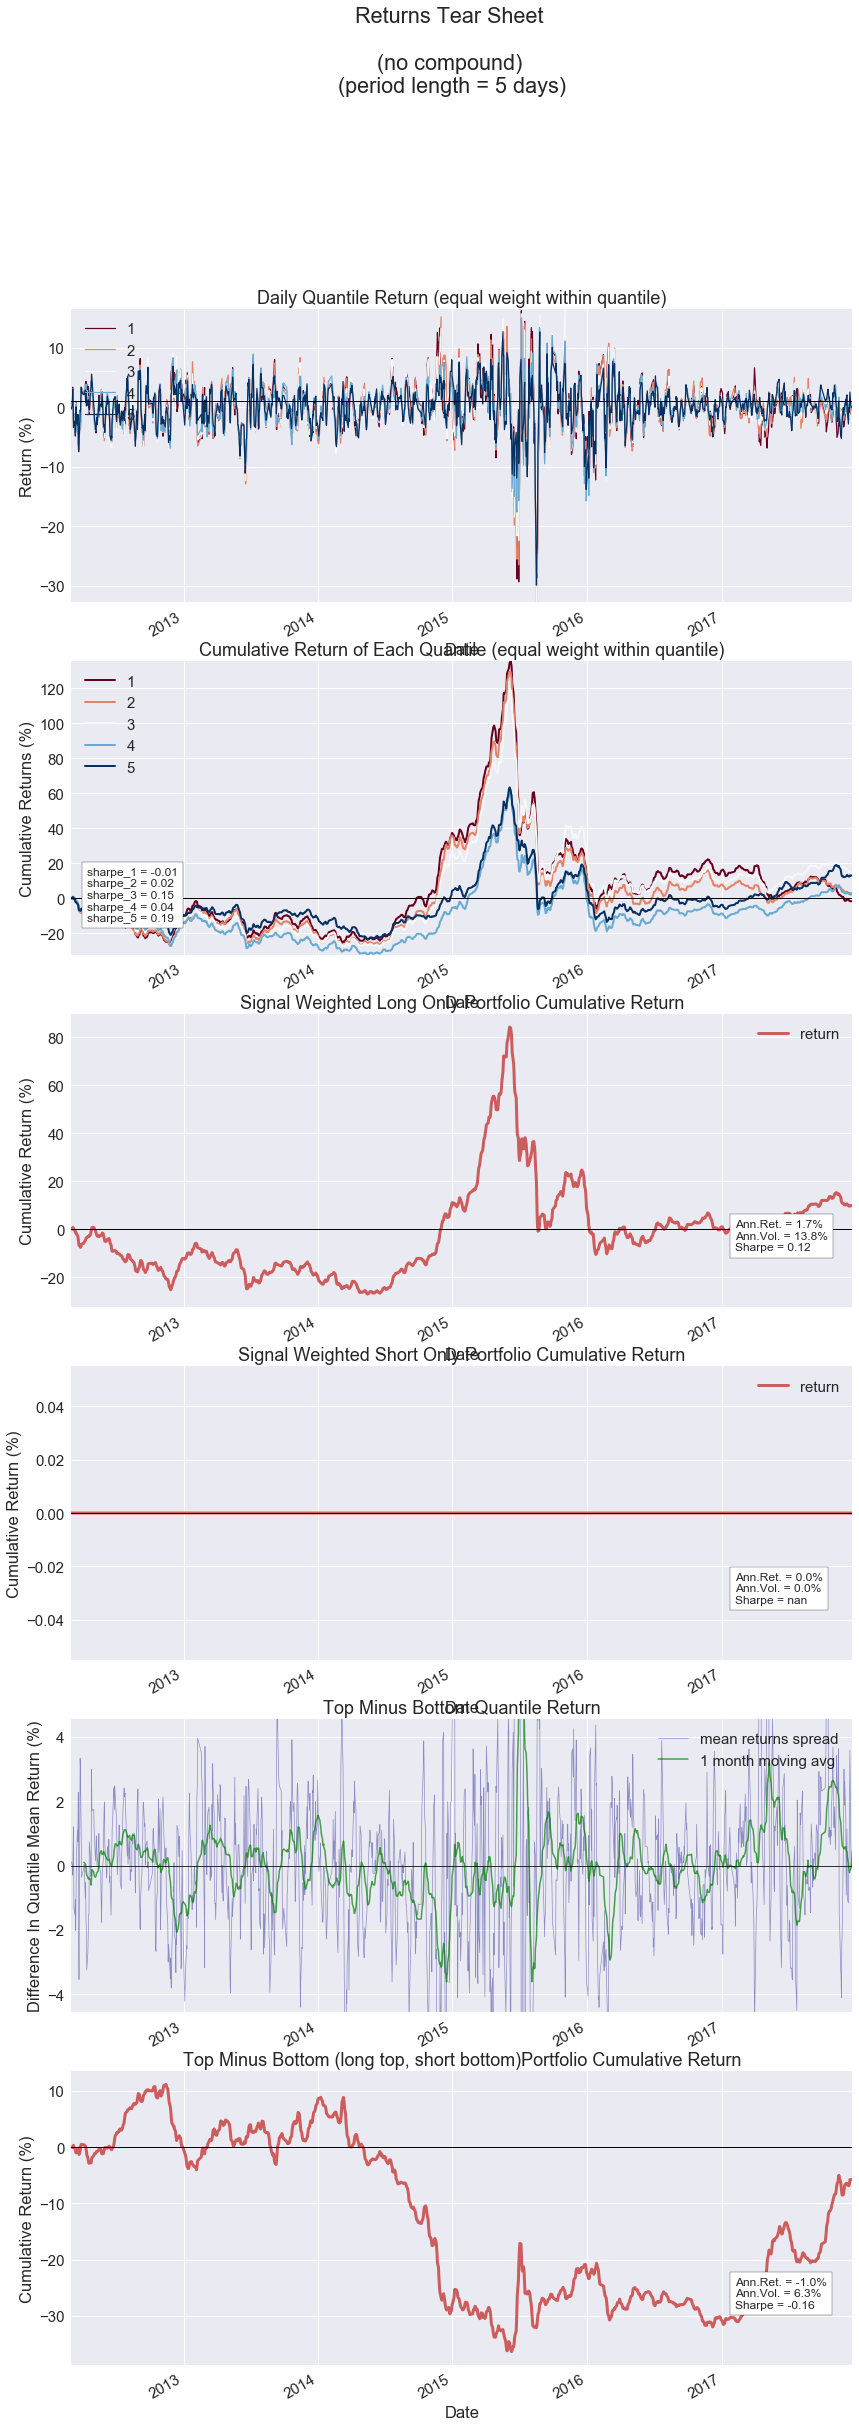

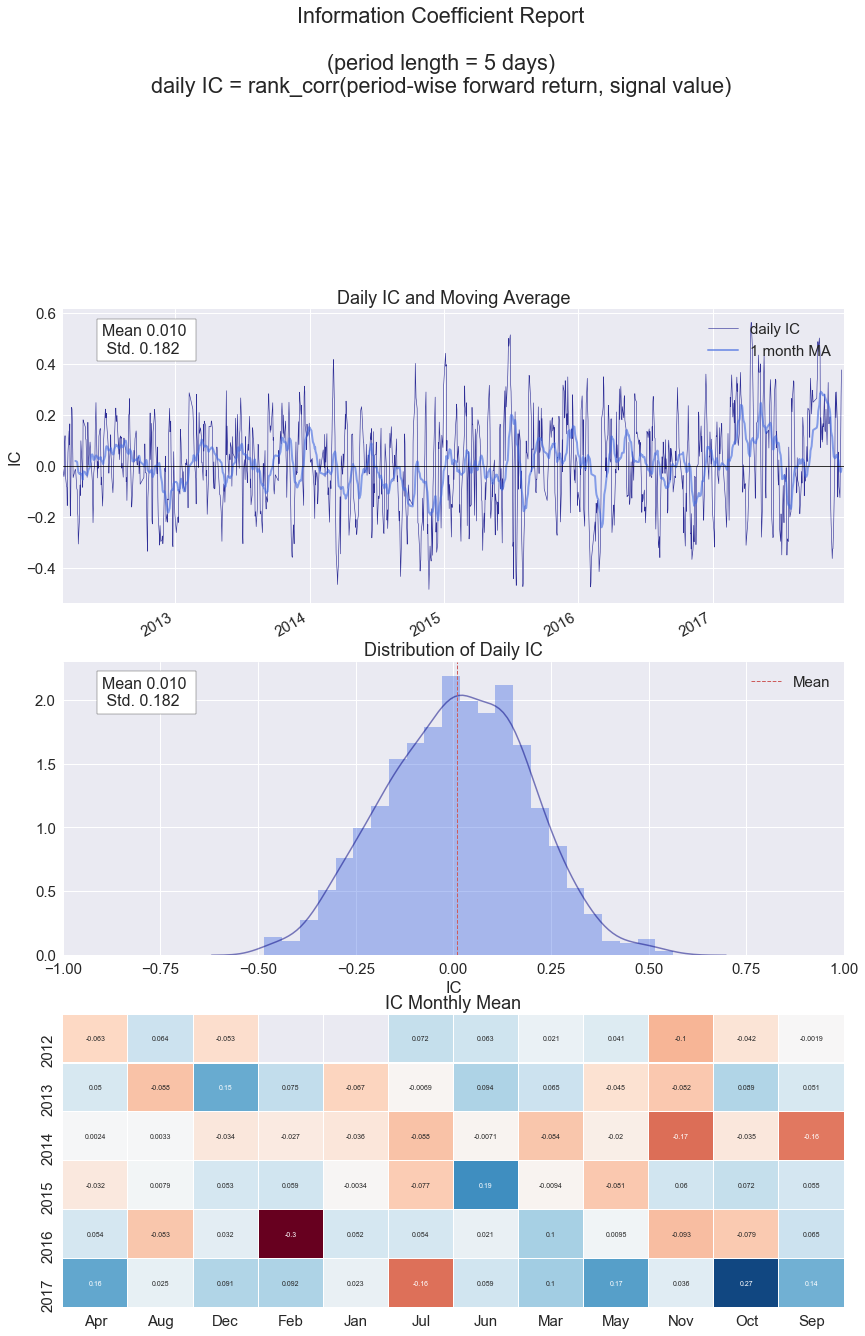

In [23]:
plot_pfm(Factor_Portfolio, 'roa_roe', 5, 5)

**2. Alphalens绩效**

In [24]:
factor = change_columns_index(Factor_Portfolio.loc['2015-09-01':]).stack()

In [25]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, price_time, quantiles=5)
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)

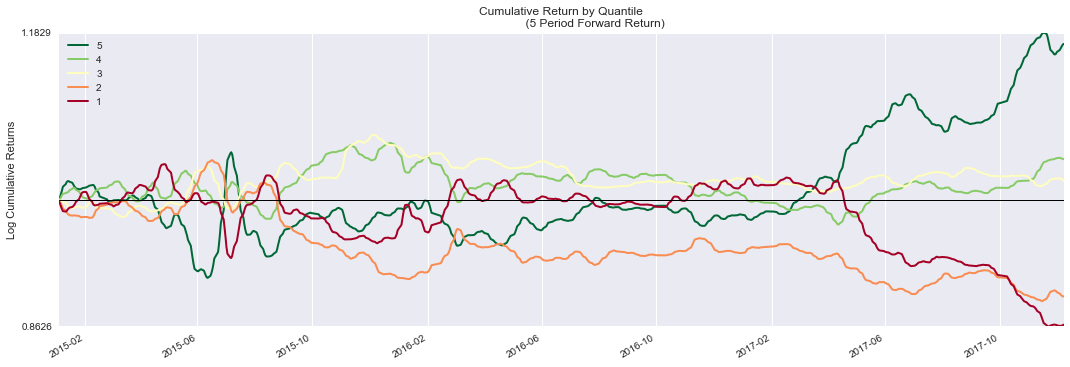

In [26]:
import matplotlib.pyplot as plt
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
plt.show()

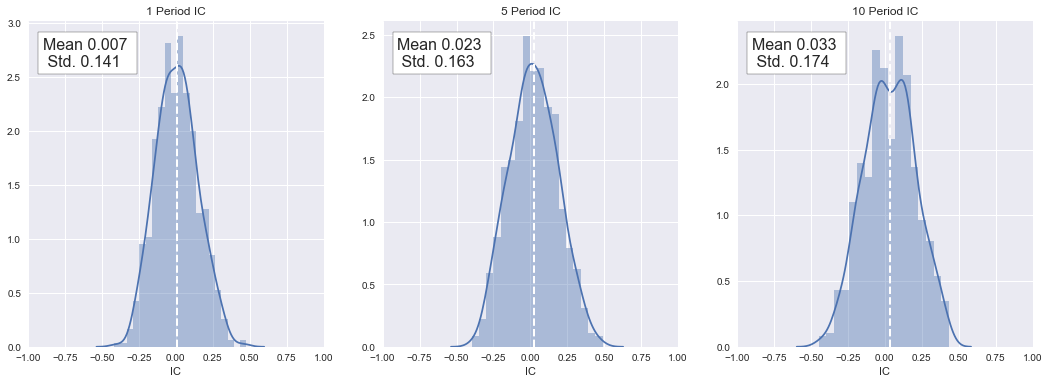

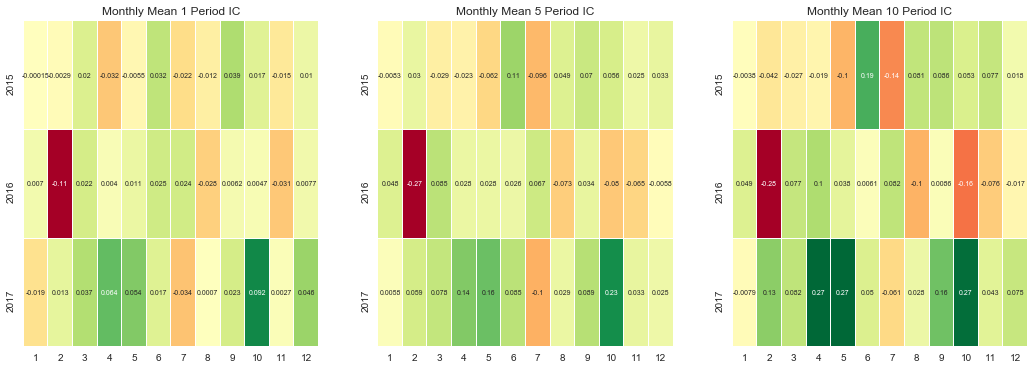

In [27]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()

## 5_交集与并集选股的方法

**PB最低的N只与ROE最高的N只的交集**

In [28]:
roe_df = dv.get_ts('roe')
pb_df = dv.get_ts('pb')

In [29]:
def largest(row, n=30):
    return pd.Series(1, row.nlargest(n).index)

def smallest(row, n=30):
    return pd.Series(1, row.nlargest(n).index)

In [30]:
from functools import partial

big_roe = roe_df.agg(partial(largest, n=10), axis=1)
small_pb = pb_df.agg(partial(smallest, n=10), axis=1)

In [31]:
Intersection_data = big_roe+small_pb

In [32]:
Intersection = Intersection_data.replace(2,1)

In [33]:
Union_data = big_roe.replace(np.nan,0)+small_pb.replace(np.nan,0)

In [34]:
Union = Union_data.replace(0, np.nan)
Union[Union>0] = 1